## Setup

In [1]:
from typing import *
from pathlib import Path

import torch
import torchmetrics
import pytorch_lightning as pl
import pytorch_lightning.callbacks as pl_callbacks
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn import preprocessing
from sklearn.model_selection import KFold

In [2]:
# Make most code deterministic
import random
import os
SEED = 1234
random.seed(SEED)
torch.manual_seed(random.randint(1, 1_000_000))
torch.cuda.manual_seed(random.randint(1, 1_000_000))
np.random.seed(random.randint(1, 1_000_000))
os.environ["PYTHONHASHSEED"] = str(random.randint(1, 1_000_000))

# Hide GPU's even if available (which also silences some annoying warnings)
%env CUDA_VISIBLE_DEVICES=""

# Disable the DataLoaders workers warning, cause we use 0 intentionally for determinism
import warnings
warnings.filterwarnings("ignore", ".*does not have many workers.*")

# Disable Torch Lightning accelerator availability message
import logging
logging.getLogger("pytorch_lightning").setLevel(logging.WARNING)

env: CUDA_VISIBLE_DEVICES=""


## Dataset

In [3]:
class SegmentDataset(Dataset):
    def __init__(self, data_dir: str = './'):
        self.data_dir = data_dir
        self.n_classes = 7
        self.label_encoder = preprocessing.LabelEncoder()
        self.scaler = preprocessing.StandardScaler()

        df = pd.read_csv(Path(self.data_dir) / 'segment.csv')
        targets = df.pop('class')
        
        # Encode labels
        self.features = pd.DataFrame(self.scaler.fit_transform(df), columns=df.columns).astype(np.float32)
        self.targets = pd.DataFrame(self.label_encoder.fit_transform(targets))

    def __getitem__(self, idx):
        return self.features.iloc[idx].to_numpy(), self.targets.iat[idx, 0] # type: ignore

    def __len__(self):
        return len(self.features)

def kfold(dataset: Dataset, n_folds: int):
    """
    Split a dataset into n_folds folds, where the test partitions are non overlapping.
    """
    length = len(dataset) # type: ignore
    splits = list(KFold(n_splits=n_folds, shuffle=True, random_state=SEED).split(range(length)))
    return [(Subset(dataset, train_indices), Subset(dataset, test_indices)) for train_indices, test_indices in splits]

class TransformDataset(Dataset):
    """
    Utility class to apply a transformation to an existing dataset.
    """
    def __init__(self, dataset: Dataset, transform):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, idx):
        return self.transform(self.dataset[idx])
    
    def __len__(self):
        return len(self.dataset) # type: ignore

class EnumerateDataset(Dataset):
    """
    Utility class to enumerate the items of an an existing dataset.
    """
    def __init__(self, dataset: Dataset):
        self.dataset = dataset
    
    def __getitem__(self, idx):
        return idx, self.dataset[idx]
    
    def __len__(self):
        return len(self.dataset) # type: ignore

## Define the task system
A small neural net with 10 hidden neurons.

In [4]:
class SegmentModel(pl.LightningModule):
    def __init__(self, hidden_dim: int = 10, num_classes: int = 7):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_classes = num_classes
        self.model = torch.nn.Sequential(
            torch.nn.Linear(19, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, num_classes),
            torch.nn.Softmax(dim=1)
        )
        # self.loss = F.nll_loss
        self.loss = torch.nn.CrossEntropyLoss()
        self.accuracy = torchmetrics.Accuracy()

    def configure_optimizers(self):  # type: ignore
        return torch.optim.Adam(self.parameters(), lr=0.007)

    def forward(self, x): # type: ignore
        return self.model(x)

    def _get_metrics(self, batch):
        x, y = batch
        logits = self(x)
        loss = self.loss(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = self.accuracy(preds, y)
        return logits, loss, acc

    def training_step(self, batch, batch_idx): #type: ignore
        _, loss, acc = self._get_metrics(batch)
        self.log('train_loss', loss, on_step=True, on_epoch=True)
        self.log('train_acc', acc, on_step=True, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx): # type: ignore
        _, loss, acc = self._get_metrics(batch)
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx): # type: ignore
        _, loss, acc = self._get_metrics(batch)
        self.log('test_acc', acc)
        return loss

In [5]:
# Some things we will reuse a couple of times
TrainDataLoader = lambda ds: DataLoader(ds, batch_size=256, shuffle=True, num_workers=0)
TestDataLoader = lambda ds: DataLoader(ds, batch_size=1024, shuffle=False, num_workers=0)
Trainer = lambda kwargs={}: pl.Trainer(
        accelerator='cpu',
        max_epochs=15,
        log_every_n_steps=5,
        enable_model_summary=False,
        callbacks=[pl_callbacks.TQDMProgressBar(refresh_rate=0)],
        **kwargs
)

## Train the population
Takes about a minute (because CPU only).

In [6]:
# Enumerating the dataset helps with managing the evaluation results later
ds = EnumerateDataset(SegmentDataset()) 

n_folds = 4
folds = kfold(ds, n_folds)
models = []
for k, (train_ds, test_ds) in enumerate(folds):
    # Remove idx from the enumerated instances (we don't need it for training).
    remove_idx = lambda idx_inst: idx_inst[1]
    train_ds = TransformDataset(train_ds, remove_idx)
    test_ds = TransformDataset(test_ds, remove_idx)
    print(f"Model {k}")

    model = SegmentModel()
    trainer = Trainer()
    trainer.fit(model, TrainDataLoader(train_ds), TestDataLoader(test_ds))
    trainer.test(model, TestDataLoader(test_ds))
    models.append(model)

Model 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.8961937427520752
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Model 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.8512110710144043
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Model 2
────────────────────────────────────────────────────────────────────

## Create Dataset of Evaluation Results

In [7]:
trainer = Trainer()
results_buffer = [] 
for syst_id, (model, (train_ds, test_ds)) in enumerate(zip(models, folds)):
    select_idx = lambda idx_inst: idx_inst[0]
    select_features = lambda idx_inst: idx_inst[1][0]
    select_target = lambda idx_inst: idx_inst[1][1]

    predict_ds = TransformDataset(test_ds, select_features)
    predictions: Any = trainer.predict(model, TestDataLoader(predict_ds))[0] # type: ignore

    df = pd.DataFrame({
        "syst_id": syst_id,
        "inst_id": list(TransformDataset(test_ds, select_idx)),       # type: ignore
        "y"      : list(TransformDataset(test_ds, select_target)), # type: ignore
        "y_hat"  : torch.argmax(predictions, dim=1),
        "conf"   : torch.max(predictions, dim=1)[0],
    })

    df['score'] = df.apply(lambda row: int(row.y == row.y_hat), axis=1)
    results_buffer.append(df)

results: pd.DataFrame = pd.concat(results_buffer, ignore_index=True) # type: ignore
print(results)

      syst_id  inst_id  y  y_hat      conf  score
0           0        0  4      4  0.549221      1
1           0        2  5      5  0.973850      1
2           0       11  6      6  0.811455      1
3           0       13  4      4  0.920242      1
4           0       14  3      3  0.983669      1
...       ...      ... ..    ...       ...    ...
2305        3     2296  2      2  0.596334      1
2306        3     2301  6      6  0.445601      1
2307        3     2304  1      0  0.497132      0
2308        3     2306  5      5  0.993515      1
2309        3     2309  0      0  0.645020      1

[2310 rows x 6 columns]


In [8]:
class EvalResultDataset(Dataset):
    def __init__(self, df: pd.DataFrame, base: Dataset):
        self.df = df
        self.base = base

    def __getitem__(self, idx):
        inst = self.base[self.df['inst_id'].iloc[idx]]
        inst_features = inst[1][0]
        syst_id = self.df['syst_id'].iloc[idx]
        score = self.df['score'].iloc[idx]
        return syst_id, inst_features, score

    def __len__(self):
        return len(self.df)

results_train: Any = results.sample(frac=0.75, random_state=SEED) 
results_test: Any = results.drop(results_train.index)
assr_train_ds = EvalResultDataset(results_train, ds)
assr_test_ds = EvalResultDataset(results_test, ds)
print(len(results), len(assr_train_ds), len(assr_test_ds))
print(assr_train_ds[0])

2310 1732 578
(2, array([-1.3286656 , -0.1986608 ,  0.        , -0.35704732, -0.1945517 ,
       -0.43423897, -0.11800148, -0.5178754 , -0.13743018, -0.81548804,
       -0.7339649 , -0.84943306, -0.8444383 ,  1.4028448 , -0.8953564 ,
        0.11027234, -0.8757806 ,  0.5134453 ,  0.19716294], dtype=float32), 1)


## Define the Assessor model

In [9]:
class SegmentAssessorModel(pl.LightningModule):
    def __init__(
        self, 
        hidden_dim: int = 10, 
        system_specialisation: int = 0,
        specialisation_weight: int = 4,
    ):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.system_specialisation = system_specialisation
        self.specialisation_weight = specialisation_weight
        self.model = torch.nn.Sequential(
            torch.nn.Linear(19+1, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, 1),
            torch.nn.Sigmoid()
        )
        self.accuracy = torchmetrics.Accuracy()

    def configure_optimizers(self):  # type: ignore
        return torch.optim.Adam(self.parameters(), lr=0.007)

    def forward(self, *args):
        syst_id, x = args
        x = torch.column_stack((x, syst_id))
        return self.model(x)

    def _get_metrics(self, batch):
        syst_id, x, y = batch
        probs = self(syst_id, x).squeeze()

        # Set higher instance weights for a specific system,
        # specialising the assessor for that system.
        syst_idx = self.system_specialisation
        idx_w = self.specialisation_weight
        weights = syst_id.squeeze().apply_(lambda idx: idx_w if idx == syst_idx else 1)

        loss = torch.nn.BCELoss(weights)(probs, y.float())
        acc = self.accuracy(probs, y)
        return probs, loss, acc

    def training_step(self, batch, _): #type: ignore
        _, loss, acc = self._get_metrics(batch)
        self.log('train_loss', loss, on_step=True, on_epoch=True)
        self.log('train_acc', acc, on_step=True, on_epoch=True)
        return loss

    def validation_step(self, batch, _): # type: ignore
        _, loss, acc = self._get_metrics(batch)
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)
        return loss

    def test_step(self, batch, _): # type: ignore
        _, loss, acc = self._get_metrics(batch)
        self.log('test_loss', loss)
        self.log('test_acc', acc)
        return loss

    def predict_step(self, batch, _): # type: ignore
        syst_id, x, = batch
        return self(syst_id, x)

## Train the Assessor model

In [10]:
assessor = SegmentAssessorModel(system_specialisation=0, specialisation_weight=4)
trainer = Trainer()
trainer.fit(assessor, TrainDataLoader(assr_train_ds), TestDataLoader(assr_test_ds))
trainer.test(assessor, TestDataLoader(assr_test_ds))

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.8564013838768005
        test_loss           0.6090085506439209
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.6090085506439209, 'test_acc': 0.8564013838768005}]

## Plot results

Note: A big difficulty in evaluating assessors, especially when comparing against specific systems, is that the overlap between the system test set and the assessor tests set can be quite small. And as with everything in AI, if test distribution != deployment distribution, aggregate metrics don't mean much anymore, so this is not easily resolved.

In [11]:
# Get assessor confidence for each instance
predict_ds = TransformDataset(assr_test_ds, lambda id_x_score: id_x_score[:2])
assr_preds = trainer.predict(assessor, TestDataLoader(predict_ds))[0] # type: ignore
assr_conf = torch.max(assr_preds, dim=1)[0] # type: ignore

# Put it together with the system results
df = results_test.copy()
df['assr_conf'] = assr_conf

# And select the results for a specific system we care about
df = df[df.syst_id == 0]
len(df)

139

Test instances shared between assessor and system x: 139


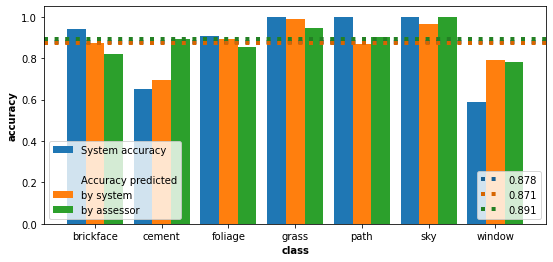

In [12]:
labels = SegmentDataset().label_encoder.classes_

def calc_stats(df):
    print(f"Test instances shared between assessor and system x:", len(df))
    return {
        "global": {
            "system_acc": df.score.mean(),
            "system_predicted_acc": df.conf.mean(),
            "assessor_predicted_acc": df.assr_conf.mean()
        },
        "per_class": {
            "system_acc": df.groupby(['y']).score.mean().to_list(),
            "system_predicted_acc": df.groupby(['y']).conf.mean().to_list(),
            "assessor_predicted_acc": df.groupby(['y']).assr_conf.mean().to_list()
        }
    }

import colorsys
def lighten(rgb, scale):
    h, l, s = colorsys.rgb_to_hls(*rgb[:-1])
    return colorsys.hls_to_rgb(h, min(1, l * scale), s=s)

def plot_stats(stats):
    fig, ax = plt.subplots(figsize=(9, 4))
    x = np.arange(len(labels))
    width = 0.28

    # Plot per-class bars
    per_class = stats['per_class']
    b1 = ax.bar(x - width * 1, per_class['system_acc'], width, label="System accuracy")
    b2 = ax.bar(x - width * 0.0, per_class['system_predicted_acc'],width,label="by system")
    b3 = ax.bar(x + width * 1,per_class['assessor_predicted_acc'],width,label="by assessor")
    
    # Draw horizontal lines for global accs
    corresponding_color = lambda bar: lighten(bar.patches[0].get_facecolor(), 0.8)
    def draw_hline(y, color, with_diff=False):
        label = f"{y:.3f}"
        line = ax.axhline(y, ls="dotted", lw=4, c=color, label=label)
        return line
    l1 = draw_hline(stats["global"]['system_acc'], corresponding_color(b1))
    l2 = draw_hline(stats["global"]['system_predicted_acc'], corresponding_color(b2))
    l3 = draw_hline(stats["global"]['assessor_predicted_acc'], corresponding_color(b3))

    # Style plot
    ax.set_xlabel("class", fontweight="bold")
    ax.set_ylabel("accuracy", fontweight="bold")
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    line_legend = ax.legend(handles=[l1, l2, l3], loc="lower right")
    ax.add_artist(line_legend)
    dummy1 = ax.bar(0, [0], label=' ', color='#00000000')
    dummy2 = ax.bar(0, [0], label='Accuracy predicted', color='#00000000')
    ax.legend(loc="lower left", handles=[b1, dummy1, dummy2, b2, b3])

stats = calc_stats(df)
plot_stats(stats)

## Plot Original Results

   inst_id  y  syst_id  score  assr_conf      conf
1     2164  3        1    1.0   0.991621  0.968752
5     2165  5        1    1.0   0.999867  0.996408
9     2166  0        1    1.0   0.862427  0.609692
Test instances shared between assessor and system x: 144


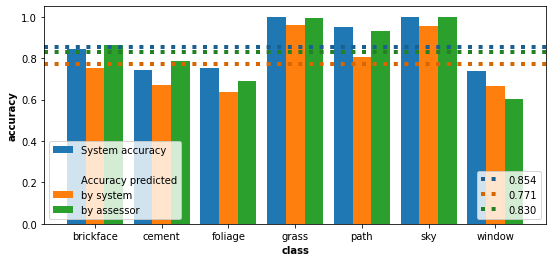

In [13]:
import json

orig = pd.read_csv("original_results.csv")
orig.drop(columns=["syst_features", "syst_pred_loss", "assr_pred_loss"], inplace=True)
orig['assr_conf'] = orig.assr_conf.apply(lambda x: np.array(json.loads(x))[0])
orig['conf'] = orig.syst_prediction.apply(lambda x: np.max(np.array(json.loads(x))))
orig.drop(columns=["syst_prediction"], inplace=True)
orig = orig[orig.syst_id == 1]
print(orig.head(3))

stats = calc_stats(orig)
plot_stats(stats)